In [1]:
import math
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write


In [2]:
def read_raw_y(file_path):
    if not os.path.isfile(file_path): 
        raise ValueError("Input file is wrong")

    return read(file_path)


def write_wav_file(file_path, fs, y):
    write(file_path, fs, y)
    
    
def reduce_amplitude(frequency_component, reduction):
    """
    Reduce the amplitude of a frequency component without changing its phase.

    Parameters:
    - frequency_component: Complex number representing the frequency component.
    - reduction_factor: Amplitude reduction factor (0 < reduction_factor < 1).

    Returns:
    - reduced_frequency_component: Complex number with reduced amplitude.
    """
    magnitude = np.abs(frequency_component)
    phase = np.angle(frequency_component)
    
    reduced_magnitude = max(magnitude - reduction,0)
    reduced_frequency_component = reduced_magnitude * np.exp(1j * phase)

    return reduced_frequency_component

In [4]:
    
def get_time_vector(signal):
    signal_len = len(signal)
    return np.linspace(0, signal_len/fs , signal_len, endpoint=False)  
    
    
def get_dft(signal):
    return np.fft.fft(signal)

    
def get_dft_and_frequencies(signal, fs):
    return np.fft.fft(signal), np.fft.fftfreq(len(signal), 1 / fs)
    
def get_signal(dft):
    return np.fft.ifft(dft)
    

def get_windows_dft_and_frequency(signal, fs, window_size, window_step):
    signal_length = len(signal)
    num_windows = (signal_length - window_size) // window_step + 1
    
    dfts = np.empty((num_windows, window_size), dtype=np.complex128)  # 2D array for DFT results
    indexes = []  # List to store indexes for each DFT
    frequency = np.fft.fftfreq(window_size, 1 / fs)
    
    for i in range(num_windows):
        start_idx = i * window_step
        end_idx = start_idx + window_size
        
        window = signal[start_idx:end_idx]
        dft_result, _ = get_dft_and_frequencies(window, fs)
        dfts[i, :] = dft_result  # Store the DFT result in the 2D array
        
        # Calculate the indexes in the original signal
        window_indexes = np.arange(start_idx, end_idx)
        indexes.append(window_indexes)
            
    return dfts, indexes, frequency


def get_frequencies_that_exists_in_all_windows(windows_dfts, frequency, min_amplitude):
    all_arrays = np.array(windows_dfts)
    condition_array = np.greater(np.abs(all_arrays), min_amplitude)    
    result_array = np.all(condition_array, axis=0).astype(int)
    return frequency[np.argwhere(result_array > 0)]

def get_frequency_range_to_filter(frequencies_to_filter, extra_filter):
    positive_frequencies = frequencies_to_filter[frequencies_to_filter > 0] 
    return np.max(np.min(positive_frequencies) - extra_filter, 0) , np.max(positive_frequencies) + extra_filter

def get_filtered_signal_dft(signal_dft, frequency, frequency_range_to_filter):
    signal_dft[np.logical_and(frequency_range_to_filter[0] < np.abs(frequency), np.abs(frequency) < frequency_range_to_filter[1])] = 0
    return signal_dft



def triangle_weighted_dfts_by_index(dfts, indexes):
    # Ensure the input arrays have the same length
    if len(dfts) != len(indexes):
        raise ValueError("The number of DFTs and indexes must be the same.")

    # Find the maximum index to determine the size of the 2D array
    max_index = np.max([np.max(idx) for idx in indexes])

    # Create a 2D array filled with zeros
    weighted_array = np.zeros((max_index + 1, len(dfts[0])), dtype=np.complex128)
    normalization_factors = np.zeros(max_index + 1)

    # Populate the array with triangle-weighted DFTs for each index
    for dft, index in zip(dfts, indexes):
        center = (index[0] + index[-1]) / 2  # Calculate the center index of the window
        distance_to_center = np.abs(index - center)
        weights = 1 - distance_to_center / (len(index) / 2)  # Triangle weighting

        weighted_array[index, :] += dft * weights[:, np.newaxis]
        normalization_factors[index] += weights

    # Normalize the result for each index separately
    weighted_array /= normalization_factors[:, np.newaxis]

    return weighted_array
    

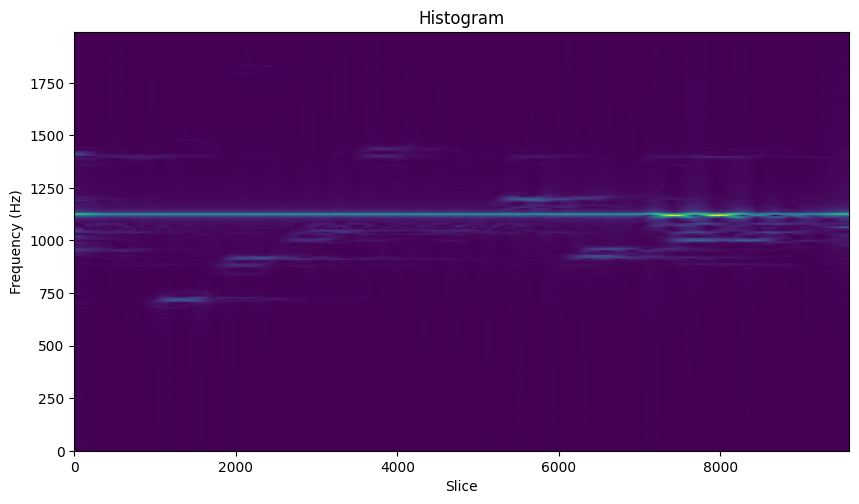

In [6]:
(fs, signal) = read_raw_y('./assets/q1.wav')
signal_dft, frequency = get_dft_and_frequencies(signal, fs)
window_size = 500
window_step = 100
windows_dfts, windows_indices, windows_frequency = get_windows_dft_and_frequency(signal, fs, window_size=window_size, window_step=window_step)
weighted_dft = triangle_weighted_dfts_by_index(windows_dfts, windows_indices)


windows_dfts_for_im = np.abs(weighted_dft[:,:math.ceil(len(weighted_dft[0])/2) ])
windows_frequency_pos = windows_frequency[:math.ceil(len(windows_frequency) / 2)]
windows_dfts_for_im_transposed = windows_dfts_for_im.T

fig_size = (10, 6)  # Adjust the width and height as needed
plt.figure(figsize=fig_size)
plt.imshow(windows_dfts_for_im_transposed, cmap='viridis', extent=[0, len(windows_dfts_for_im_transposed[0]), windows_frequency_pos[-1], windows_frequency_pos[0]])
plt.title('Histogram')
plt.xlabel('Slice')
plt.ylabel('Frequency (Hz)')
plt.gca().invert_yaxis()
plt.gca().set_aspect( 100/ (len(windows_dfts_for_im_transposed[0]) / len(windows_frequency_pos  )))
plt.show()




In [317]:
weighted_dft.shape

(9600, 500)

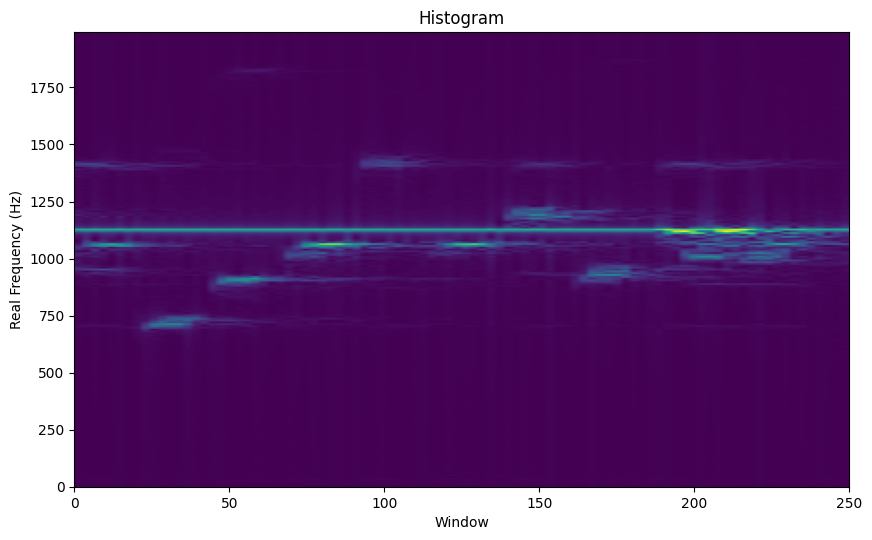

In [339]:

windows_dfts_for_im = np.abs(windows_dfts[:,:math.ceil(len(windows_dfts[0])/2) ])
windows_frequency_pos = windows_frequency[:math.ceil(len(windows_frequency) / 2)]
windows_dfts_for_im_transposed = windows_dfts_for_im.T

fig_size = (10, 6)  # Adjust the width and height as needed
plt.figure(figsize=fig_size)
plt.imshow(windows_dfts_for_im_transposed, cmap='viridis', extent=[0, len(windows_dfts_for_im_transposed), windows_frequency_pos[-1], windows_frequency_pos[0]])
plt.title('Histogram')
plt.xlabel('Window')
plt.ylabel('Real Frequency (Hz)')
plt.gca().invert_yaxis()
plt.gca().set_aspect((len(windows_dfts_for_im_transposed[0]) / len(windows_frequency_pos)) / 5)
plt.show()

<BarContainer object of 500 artists>

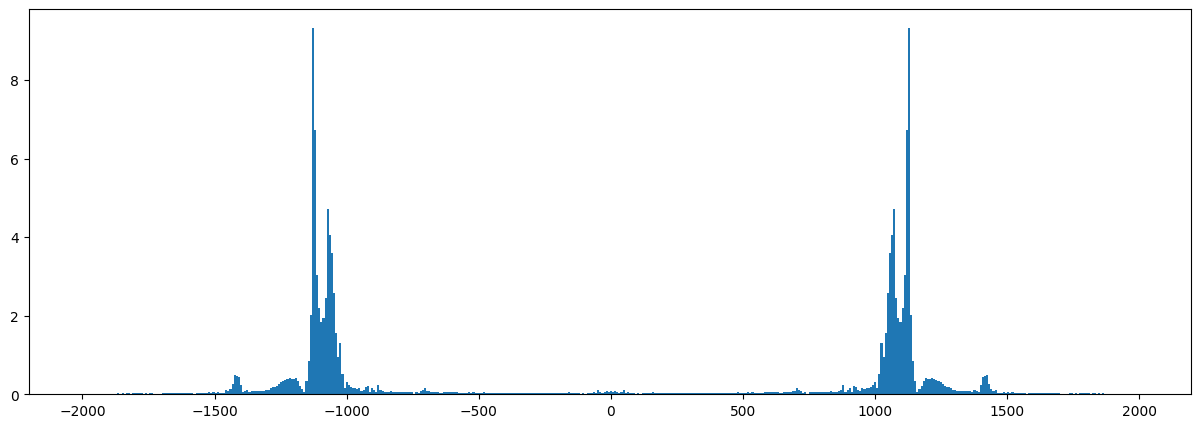

In [328]:
def get_bar_width(frequency, width_percent=1):
    return width_percent*(frequency[1] - frequency[0])

# windows_frequency
n = 100

plt.figure(figsize=(15, 5))  # Adjust the width and height as needed
bar_width = get_bar_width(windows_frequency)   # Adjust the width of the bars as needed
plt.bar(windows_frequency, np.abs(windows_dfts[50]), width=bar_width) #np.abs(windows_dfts[0]))



<BarContainer object of 500 artists>

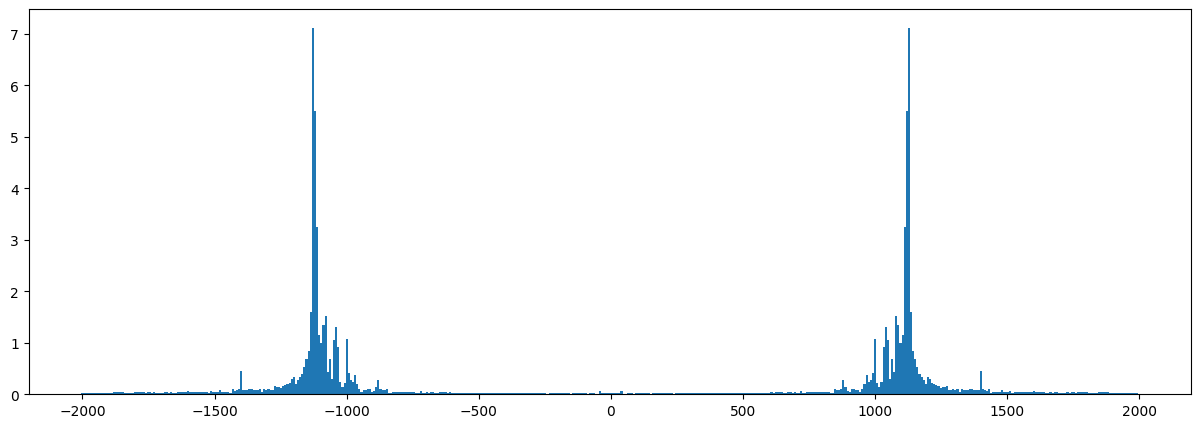

In [330]:
plt.figure(figsize=(15, 5))  # Adjust the width and height as needed
bar_width = get_bar_width(windows_frequency)   # Adjust the width of the bars as needed
plt.bar(windows_frequency, np.abs(weighted_dft[9000]), width=bar_width) #np.abs(windows_dfts[0]))



In [186]:
np.abs(histogram[0][3781])

0.0

100